In [ ]:
!pip install opendatagen --upgrade --force-reinstall
!pip install matplotlib

In [ ]:
!export OPENAI_API_KEY='your_openai_api_key' 
!export MISTRAL_API_KEY='your_mistral_api_key'

#Code to generate the dataset  

from opendatagen.data_generator import DataGenerator
from opendatagen.model import OpenAIChatModel, MistralChatModel
from opendatagen.template import TemplateManager
from mistralai.models.chat_completion import ChatMessage

template_file_path = "template.json"
template_name = "factuality"
output_path = "factuality.csv"

manager = TemplateManager(template_file_path=template_file_path)

template = manager.get_template(template_name=template_name)

if template:
    
    generator = DataGenerator(template=template)
    
    data = generator.generate_data(output_path=output_path)
    

In [ ]:
import pandas as pd 
from opendatagen.data_generator import DataGenerator
from opendatagen.model import OpenAIChatModel, MistralChatModel
from opendatagen.template import TemplateManager
from mistralai.models.chat_completion import ChatMessage

# Assuming 'factuality.csv' is in the same folder and has columns 'question' and 'answer'
df = pd.read_csv('factuality.csv')

# Initialize counters for each model
true_counts = {'mistral-tiny': 0, 'mistral-small': 0, 'mistral-medium': 0, 'GPT35': 0}
total_counts = {'mistral-tiny': 0, 'mistral-small': 0, 'mistral-medium': 0, 'GPT35': 0}

for index, row in df.iterrows():

    #print(f"Processing {index + 1}/{len(df)}")

    question = row['question']
    reference_answer = row['answer']
    
    mistral7b = MistralChatModel(name="mistral-tiny", max_tokens=64, temperature=[0])
    mistra8x7b = MistralChatModel(name="mistral-small", max_tokens=64, temperature=[0])
    mistraX = MistralChatModel(name="mistral-medium", max_tokens=64, temperature=[0])
    gpt35 = OpenAIChatModel(name="gpt-3.5-turbo-1106", max_tokens=64, temperature=[0])

    system_prompt_evaluator = "You are EvaluatorGPT, given the question and the reference answer please determine if the new answer is True or False. Only answer with 'True' or 'False'. No verbose."

    mistral_messages = [ChatMessage(role="user", content=f"Answer accurately and consicely to the following question:\n{question}")]

    gpt_messages = [
            {"role":"system", "content": "Answer to the question consicely."},
            {"role":"system", "content": f"Question:\n{question}"}
        ]

    answer7b = mistral7b.ask(messages=mistral_messages)
    answer8x7b = mistra8x7b.ask(messages=mistral_messages)
    answerX = mistraX.ask(messages=mistral_messages)
    answergpt35 = gpt35.ask(messages=gpt_messages)

    # For each model, evaluate the answer
    for model_name, model_answer in [('mistral-tiny', answer7b), ('mistral-small', answer8x7b), ('mistral-medium', answerX), ('GPT35', answergpt35)]:
        
        evaluator = OpenAIChatModel(name="gpt-4-1106-preview", max_tokens=5, system_prompt=system_prompt_evaluator)
        #evaluator = MistralChatModel(name="mistral-medium", max_tokens=5, temperature=[0])

        evaluator_messages = [
            {"role":"system", "content": system_prompt_evaluator},
            {"role":"system", "content": f"Question:\n{question}\nReference answer:\n{reference_answer}\nNew answer:\n{model_answer}"}
        ]
        
        '''
        evaluator_messages = [
            ChatMessage(role="system", content=system_prompt_evaluator),
            ChatMessage(role="user", content=f"Question:\n{question}\nReference answer:\n{reference_answer}\nNew answer:\n{model_answer}") 
        ]
        '''

        evaluator_answer = evaluator.ask(messages=evaluator_messages)

        if "true" in evaluator_answer.lower().strip():
            true_counts[model_name] += 1
        total_counts[model_name] += 1

# Calculate and display the results
for model_name in true_counts:
    accuracy = (true_counts[model_name] / total_counts[model_name]) * 100
    print(f"Model {model_name}: {accuracy:.2f}% True answers")

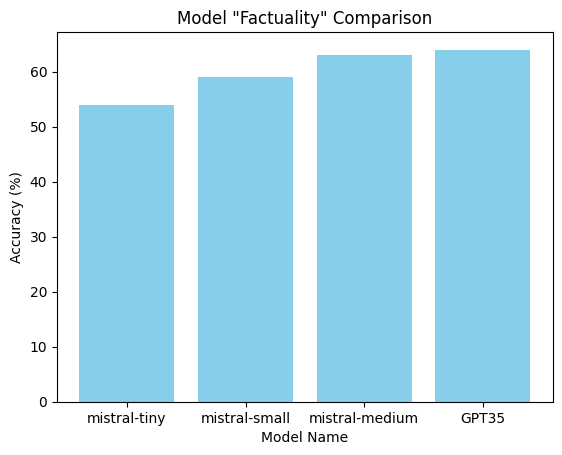

In [7]:
import matplotlib.pyplot as plt

# Calculate accuracies
accuracies = {model_name: (true_counts[model_name] / total_counts[model_name]) * 100 for model_name in true_counts}

# Names of models
model_names = list(accuracies.keys())

# Accuracy values
accuracy_values = list(accuracies.values())

# Create a bar chart
plt.bar(model_names, accuracy_values, color='skyblue')

# Adding title and labels
plt.title('Model "Factuality" Comparison')
plt.xlabel('Model Name')
plt.ylabel('Accuracy (%)')

# Save the plot as an image file
plt.savefig('comparison.png')  #You can change the file name and format (e.g., .jpg, .png, etc.)

# Show the plot
plt.show()